## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [2]:
# read files
train_df = pd.read_csv('train_set.csv', encoding='latin-1')
test_df = pd.read_csv('test_set.csv')

In [3]:
train_df.head()

,label,text
0,85389000,pdscpm gb part of panel of chiller
1,85389000,nm p economical extended rot hand parts for c...
2,85389000,lv ma pd trip unit for cvs parts of circuit br...
3,85389000,lv na p trip unit for cvs switch parts of circ...
4,85389000,lv tmd pd trip unit for cvs parts of circuitbr...


In [4]:
test_df.head()

,text
0,lv tmd pd trip unit for nh parts of circuit br...
1,module tm analog outputs analog output expansi...
2,command group t iii mechanismt p parts forcir...
3,parts of relayelectrical contact issu e f xxup
4,parts for programmable logic controllers dm ...


In [5]:
# replace labels with index labels for simplicity
# and remove duplicates
idx2labels = dict(enumerate(train_df['label'].unique()))
labels2idx = {v:k for (k,v) in idx2labels.items()}

train_df = train_df.replace({"label": labels2idx})
train_df = train_df.drop_duplicates().reset_index(drop=True)
train_df = train_df.sample(frac=1).reset_index(drop=True)
print(labels2idx)

{85389000: 0, 85177090: 1, 85369090: 2, 39269099: 3, 73181500: 4, 85366990: 5, 85364900: 6, 85238090: 7, 87089900: 8, 33041000: 9, 87082900: 10, 84713010: 11}


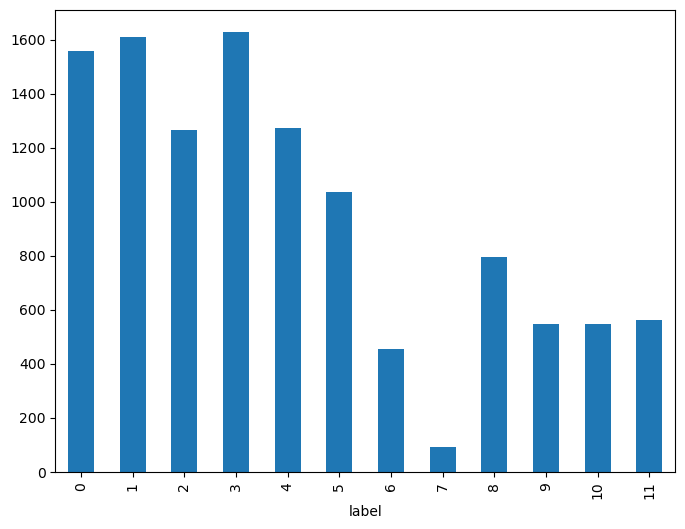

In [6]:
# count plot of labels
ig = plt.figure(figsize=(8,6))
train_df.groupby('label').text.count().plot.bar(ylim=0)
plt.show()

In [7]:
#using TfidfVectorizer to convert message into TF-IDF weighted vectors
from sklearn.feature_extraction.text import TfidfVectorizer 
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(train_df.text).toarray()
labels = train_df.label
print(features.shape)
print(labels.shape)

(11372, 3611)
(11372,)


## Define and Train different models

In [9]:
# training different ml models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=7, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0, max_iter=1000),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    # gives the name of model
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    # store accuracy of each model for each fold
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

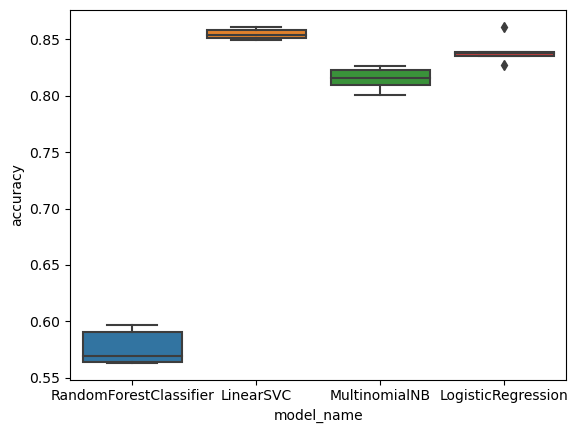

In [10]:
# visualize the score of each model using boxplot
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
plt.show()

In [11]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.854731
LogisticRegression        0.839958
MultinomialNB             0.814895
RandomForestClassifier    0.576943
Name: accuracy, dtype: float64

## Train LinearSVC model and Analyze

In [12]:
# As LinearSVC has the highest mean accuracy.
from sklearn import metrics
from sklearn.model_selection import train_test_split
model = LinearSVC() 
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

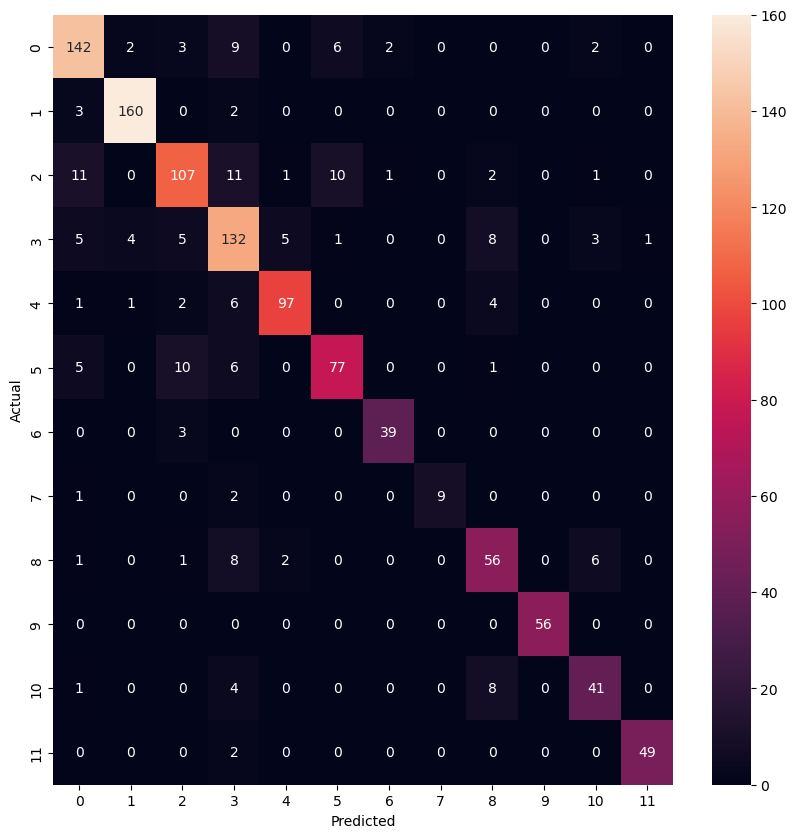

In [13]:
# visualize the result using headmap
conf_mat = metrics.confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [14]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       166
           1       0.96      0.97      0.96       165
           2       0.82      0.74      0.78       144
           3       0.73      0.80      0.76       164
           4       0.92      0.87      0.90       111
           5       0.82      0.78      0.80        99
           6       0.93      0.93      0.93        42
           7       1.00      0.75      0.86        12
           8       0.71      0.76      0.73        74
           9       1.00      1.00      1.00        56
          10       0.77      0.76      0.77        54
          11       0.98      0.96      0.97        51

    accuracy                           0.85      1138
   macro avg       0.87      0.85      0.86      1138
weighted avg       0.85      0.85      0.85      1138



## Save and Load Model

In [15]:
import pickle
 
filename = 'models/svc_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [16]:
model = pickle.load(open(filename, 'rb'))

In [17]:
# predict the labels for test set 
test_data = tfidf.transform(test_df.text).toarray()
test_pred = model.predict(test_data)

test_df['label'] = test_pred
test_df = test_df.replace({"label": idx2labels})
test_df.to_csv("predicted_test_set.csv", index=False)
print("Complete!")

Complete!
